In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import optuna

In [2]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df = pd.read_excel("../datasets/jena_climate.xlsx")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df["Date Time"] = pd.to_datetime(df["Date Time"], dayfirst = True)
df.set_index("Date Time", inplace=True)
df = df[["Tpot (K)"]]
df = df.sort_index()
df = df.iloc[::144]

train_size = int(len(df) * 0.8)
df_train_raw = df.iloc[:train_size]
df_test_raw = df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train_raw)
scaled_test = scaler.transform(df_test_raw)

In [5]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [6]:
X_train, y_train = create_sequences(scaled_train)
X_test, y_test = create_sequences(scaled_test)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

In [8]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size=1, d_model=64, nhead=2, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        x = self.input_linear(src)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        out = self.decoder(x[:, -1, :])
        return out

device = torch.device("cpu")

In [9]:
def evaluate(model, loader, scaler):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            actuals.append(yb.numpy())
    preds = np.vstack(preds)
    actuals = np.vstack(actuals)
    preds_inv = scaler.inverse_transform(preds)
    actuals_inv = scaler.inverse_transform(actuals)
    rmse = math.sqrt(mean_squared_error(actuals_inv, preds_inv))
    return preds_inv, actuals_inv, rmse

In [10]:
def objective(trial):
    set_seeds()

    # Hyperparameter search space
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    nhead = trial.suggest_categorical('nhead', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.05, 0.3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Model and training components
    model = TransformerTimeSeries(d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Proper train/val split BEFORE wrapping into TensorDataset
    val_ratio = 0.1
    val_size = int(len(X_train) * val_ratio)
    train_size = len(X_train) - val_size

    X_train_actual = X_train[:train_size]
    y_train_actual = y_train[:train_size]
    X_val = X_train[train_size:]
    y_val = y_train[train_size:]

    train_dataset = TensorDataset(X_train_actual, y_train_actual)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Early stopping parameters
    early_stopping_patience = 5
    best_val_loss = float('inf')
    epochs_no_improve = 0
    max_epochs = 50

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_losses.append(loss.item())
        val_loss = sum(val_losses) / len(val_losses)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            break

    return best_val_loss

In [11]:
set_seeds(42)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=25)
best_params = study.best_params

[I 2025-05-26 16:18:34,838] A new study created in memory with name: no-name-0b6c4863-8d92-4cc7-aa2e-f81f04bef4ea
[I 2025-05-26 16:19:10,622] Trial 0 finished with value: 0.004181735857855529 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dropout': 0.2665440364437338, 'lr': 0.0015930522616241021, 'batch_size': 64}. Best is trial 0 with value: 0.004181735857855529.
[I 2025-05-26 16:21:39,836] Trial 1 finished with value: 0.003981579095125198 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 2, 'dropout': 0.12280728504951048, 'lr': 0.0016738085788752138, 'batch_size': 64}. Best is trial 1 with value: 0.003981579095125198.
[I 2025-05-26 16:25:56,775] Trial 2 finished with value: 0.0034398224197502714 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dropout': 0.09263103092182289, 'lr': 0.00013492834268013249, 'batch_size': 32}. Best is trial 2 with value: 0.0034398224197502714.
[I 2025-05-26 16:27:28,629] Trial 3 finished with value: 0.003719266942547013

In [12]:
batch_size = best_params['batch_size']
model = TransformerTimeSeries(
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-5)

In [13]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

max_epochs = 100  # Set to a reasonable fixed value

print("Starting final training on full training data...")

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{max_epochs} Train Loss: {epoch_loss:.6f}")

# No model.load_state_dict() — we're training fully without early stopping

Starting final training on full training data...
Epoch 1/100 Train Loss: 0.101917
Epoch 2/100 Train Loss: 0.007809
Epoch 3/100 Train Loss: 0.007938
Epoch 4/100 Train Loss: 0.006523
Epoch 5/100 Train Loss: 0.005715
Epoch 6/100 Train Loss: 0.005681
Epoch 7/100 Train Loss: 0.005374
Epoch 8/100 Train Loss: 0.004743
Epoch 9/100 Train Loss: 0.004550
Epoch 10/100 Train Loss: 0.004924
Epoch 11/100 Train Loss: 0.004601
Epoch 12/100 Train Loss: 0.004734
Epoch 13/100 Train Loss: 0.004454
Epoch 14/100 Train Loss: 0.004749
Epoch 15/100 Train Loss: 0.004397
Epoch 16/100 Train Loss: 0.004452
Epoch 17/100 Train Loss: 0.004690
Epoch 18/100 Train Loss: 0.004239
Epoch 19/100 Train Loss: 0.004536
Epoch 20/100 Train Loss: 0.004226
Epoch 21/100 Train Loss: 0.004311
Epoch 22/100 Train Loss: 0.004279
Epoch 23/100 Train Loss: 0.004487
Epoch 24/100 Train Loss: 0.004906
Epoch 25/100 Train Loss: 0.004039
Epoch 26/100 Train Loss: 0.004312
Epoch 27/100 Train Loss: 0.004146
Epoch 28/100 Train Loss: 0.004304
Epoch 29

In [14]:
train_pred_inv, y_train_inv, train_rmse = evaluate(model, train_loader, scaler)
print(f"Train RMSE: {train_rmse:.4f}")

Train RMSE: 3.2910


In [23]:
pred_path = "predictions/Weather_Transformer_train.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, train_pred_inv)

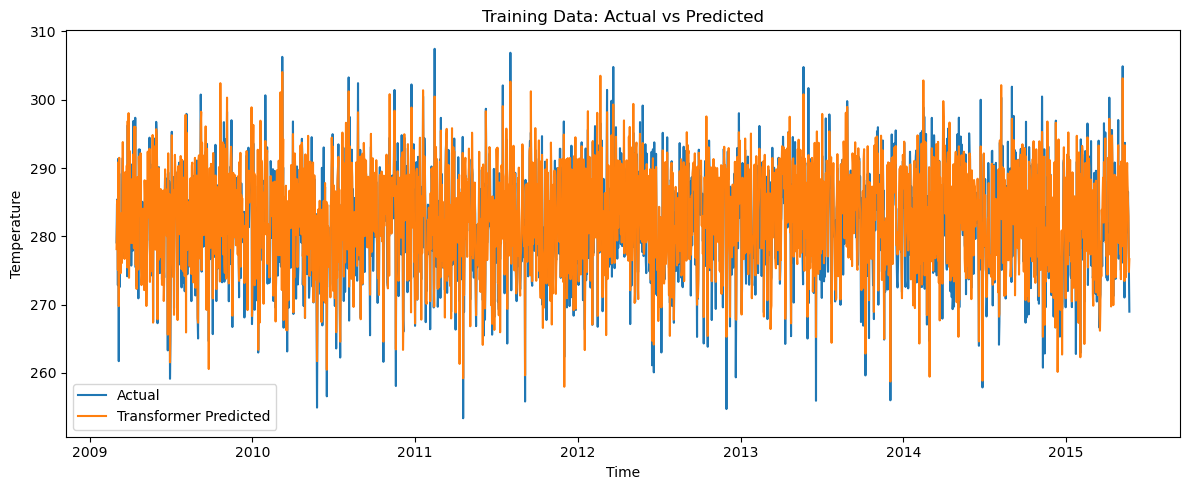

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df_train_raw.index[-len(train_pred_inv):], y_train_inv, label='Actual')
plt.plot(df_train_raw.index[-len(train_pred_inv):], train_pred_inv, label='Transformer Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_pred_inv, y_test_inv, test_rmse = evaluate(model, test_loader, scaler)
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 3.5128


In [21]:
dataset_name = "Weather"
rmse_file = "RMSE_Transformer.json"
try:
    with open(rmse_file, "r") as f:
        rmse_data = json.load(f)
except FileNotFoundError:
    rmse_data = {}

rmse_data[dataset_name] = round(test_rmse, 2)
with open(rmse_file, "w") as f:
    json.dump(rmse_data, f, indent=4)

In [22]:
pred_path = "predictions/Weather_Transformer_test.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, test_pred_inv)

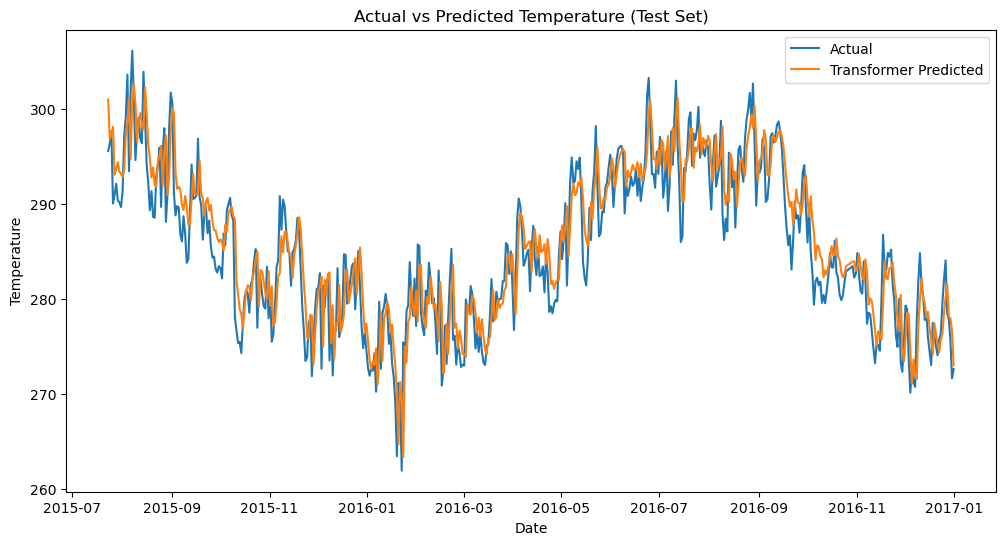

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df_test_raw.index[-len(test_pred_inv):], y_test_inv, label='Actual')
plt.plot(df_test_raw.index[-len(test_pred_inv):], test_pred_inv, label='Transformer Predicted')
plt.title('Actual vs Predicted Temperature (Test Set)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()